## Celem projektu jest zastosowanie modeli klasyfikacji do oceny wydźwięku recenzji trzech serwisów: Yelp, IMDB oraz Amazona

## Etapy projektu:

#### 1. Wczytanie danych 
#### 2. Oczyszczanie tekstu: 
            a) Basic tokenizer
            b) Tokenizer z lematyzacją WordNetLemmatizer
            c) Tokenizer z lematyzacją pakietu SpaCy
#### 3. Transformacja macierzy słów:
            a) CountVectorizer - macierze liczności TDM
            b) TdIdfVectorizer - macierze TdIdf
            c) HashingVectorizer
* Na tym etapie przygotowano 9 różnych preprocessorów, będących kombinacją punktów 2 i 3

#### 4. Klasyfikacja:
            a) Regresja logistyczna
            b) Multinomial NB
            c) Random Forests
            d) SVC
#### 5. Ocena klasyfikatorów i wybór najlepszego
            a) Classification Report

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string 
import seaborn as sns

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Wczytanie danych

#### Analizowane dane obejmują recenzje użytkowników trzech serwisów: Yelp, IMDB oraz Amazona. 

Poniższy kod wczytuje dane z 3 podzielonych zbiorów, a następnie je łączy.  
W przypadku błędnego połączenia danych (niezgodna liczba wierszy), wyświetli się komunikat o błędzie.

In [186]:
yelp = pd.read_csv('yelp_labelled.txt', sep="\t", header=None, names=['text','sentiment'])
imdb = pd.read_csv('imdb_labelled.txt', sep="\t", header=None, names=['text','sentiment'])
amazon = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None, names=['text','sentiment'])

df = pd.concat([yelp, imdb, amazon])
if(yelp.shape[0]+imdb.shape[0]+amazon.shape[0] != df.shape[0]):
    print('Błąd podczas łączenia danych')
    
print(f'Liczba wszystkich wierszy: {df.shape[0]}')

Liczba wszystkich wierszy: 2748


In [8]:
df.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Dane składają się z dwóch kolumn: 
- text - przechowującej recenzję użytkownika,
- sentiment - przechowującej informację o sentymencie wypowiedzi: 1, jeśli pozytywna i 0, jeśli negatywna.

#### Analiza sentymentu - jak rozkładają się opinie użytkowników?

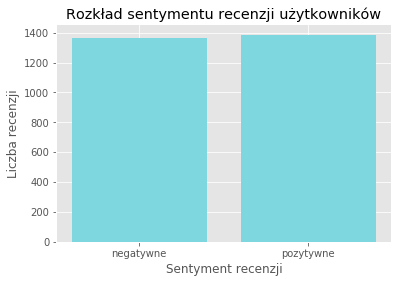

In [65]:
sentiment_count = df.groupby('sentiment').count()
plt.style.use('ggplot')
plt.bar(sentiment_count.index.values, sentiment_count['text'], color='#7ed6df')
plt.xlabel('Sentyment recenzji')
plt.ylabel('Liczba recenzji')
plt.title("Rozkład sentymentu recenzji użytkowników")
plt.xticks(sentiment_count.index.values, ['negatywne','pozytywne'])
plt.show()

Jak widać na wykresie, zbiór recenzji jest prawie równo podzielony na recenzje pozytywne i negatywne.  
Niewymagane jest balansowanie klas.

#### Jakie słowa pojawiają się najczęściej w zbiorze recenzji?

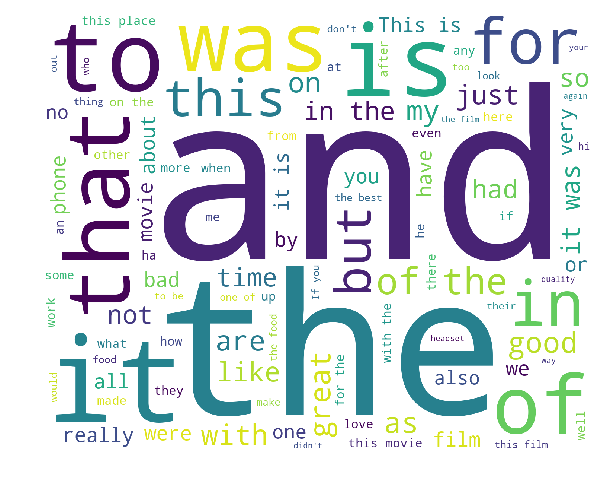

In [11]:
from wordcloud import WordCloud

wc = WordCloud(max_words=100, margin=10, background_color='white', stopwords=[],
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(df.text))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Jak widać na powyższym wykresie, najczęściej pojawiające się słowa to: "the" i "and", a następnie pozostałe przyimki.   Takie słowa to stopwordsy, które należy usunąć na etapie oczyszczania tekstu. Nie niosą one istotnej informacji na temat wydźwięku recenzji (pozytywna / negatywna).

# Oczyszczanie tekstu

#### W celu przetestowania różnych metod oczyszczania tekstu, wykorzystałem:
- 2 pakiety: nltk oraz spacy,
- 2 metody lematyzacji: WordNetLemmatizer oraz lematyzację wbudowaną w pakiet spacy,
- własną metodę oczyszczania tekstu w celu poprawy wyników. 

#### W celu zweryfikowania, jak działają poszczególne kombinacje metod oczyszczania tekstu oraz przekształcenia macierzy, zbudowałem dwudokumentowy korpus, na którym sprawdzam i porównuję wyniki algorytmów. 

In [9]:
corpus = [df.iloc[1].text, df.iloc[4].text]
print(corpus)

['Crust is not good.', 'The selection on the menu was great and so were the prices.']


#### Kod ułatwiający wyświetlenie przekszałconej macierzy:

In [10]:
# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

# 1. Basic tokenizer

Poniższy tokenizer oczyszcza tekst poprzez:
- podział tekstu na słowa (words),
- zamianę wszystkich liter na małe,
- usunięcie znaków interpunkcyjnych (lista string punctuation),
- usunięcie cyfr,
- usunięcie stopwordów ze zbioru stopwords.words('english')

In [11]:
def basic_tokenizer(words):
    words = word_tokenize(words)
    words = [w.lower() for w in words]
    words = [w for w in words if not w in string.punctuation]
    words = [w for w in words if not w.isdigit()]
    words = [w for w in words if not w in set(stopwords.words('english'))]
    return words

# 2. Tokenizer z lematyzacją WordNetLemmatizer

Poniższy tokenizer oczyszcza tekst poprzez:
- zastosowanie wszystkich metod z sekcji Basic tokenizera,
- dodanie lematyzacji słów z biblioteki WordNetLemmatizer

### WordNetLemmatizer

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemming_tokenizer(words):
    words = word_tokenize(words)
    words = [w.lower() for w in words]
    words = [w for w in words if not w in string.punctuation]
    words = [w for w in words if not w.isdigit()]
    words = [w for w in words if not w in set(stopwords.words('english'))]
    words = [wordnet_lemmatizer.lemmatize(w) for w in words]
    return words

Najpopularniejszy lemmatyzer, będący częścią pakietu nltk. Chociaż jest ogólnodostępny i zawiera dużą bazę angielskich słów,  nie do końca poprawnie radzi sobie z odmianą wszystkich słów. Najpopularniejszy "błąd" - brak odmiany "to be". Lemmatyzer nie poradził sobie także ze stopniowaniem przymiotników.  
  
Przykłady poniżej:

In [96]:
print(wordnet_lemmatizer.lemmatize('are'))
print(wordnet_lemmatizer.lemmatize('apples'))
print(wordnet_lemmatizer.lemmatize('better'))

are
apple
better


Jak widać, słowo "are" nie zostało zamienione na "to be", a przymiotnik stopniowalny "better" nie został sprowadzony do podstawowego rdzenia słowa.  
Pakiet poradził sobie za to z liczbą mnogą rzeczowników.

### Użycie WordNet Lemmatizer na zbiorze słów z recenzji

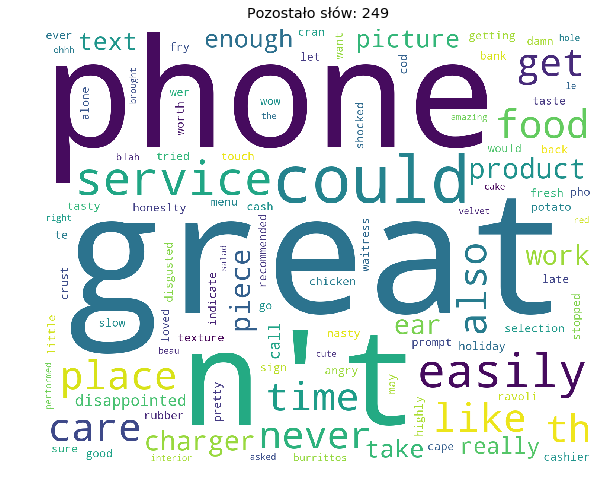

In [220]:
df_text_str = str(df.text)
df_text_lemming_tokenizer = lemming_tokenizer(df_text_str)
len_lemming_tokenizer = 'Pozostało słów: ' + str(len(df_text_lemming_tokenizer))

wc = WordCloud(max_words=100, margin=10, background_color='white', stopwords=[],
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(df_text_lemming_tokenizer))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.title(len_lemming_tokenizer)
plt.axis("off")
plt.show()

#### Użycie lematyzacji WordNet spowodowało, że ze zbioru 3516 słów pochodzących z recenzji, pozostało ich 249.   
  
Lematyzer dobrze poradził sobie z większością słów, będących stopwordami, natomiast pozostawił niektóre skróty typu "n't" lub "th". 

# 3. Tokenizer z lematyzacją w pakiecie Spacy

Poniższy tokenizer oczyszcza tekst poprzez:
- zastosowanie parsera tekstu, 
- lematyzację,
- usunięcie znaków interpunkcyjnych (lista string punctuation) i stopwordów ze zbioru stopwords.words('english')

In [13]:
from spacy.lang.en import English
parser = English()

def spacy_tokenizer(words):
    words = parser(words)
    words = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words]
    words = [word for word in words if (word not in set(stopwords.words('english')) and word not in string.punctuation)]     
    return words

Lemmatyzer wykorzystujący określenia części mowy do jeszcze trafniejszego sprowadzania słów do podstawowej formy. W porównaniu do WordNet Lemmatizer, poradził sobie z odmianą "to be" oraz stopniowaniem przymiotników.   
  
Przykłady:

In [94]:
sentence = "are apples better"
doc = parser(sentence)
" ".join([token.lemma_ for token in doc])

'be apple well'

Lemmatyzer zamienił poprawnie "are" na "to be" oraz poradził sobie ze stopniowaniem przymiotników i liczbą mnogą rzeczowników.

### Użycie lematyzacji SpaCY na zbiorze słów z recenzji

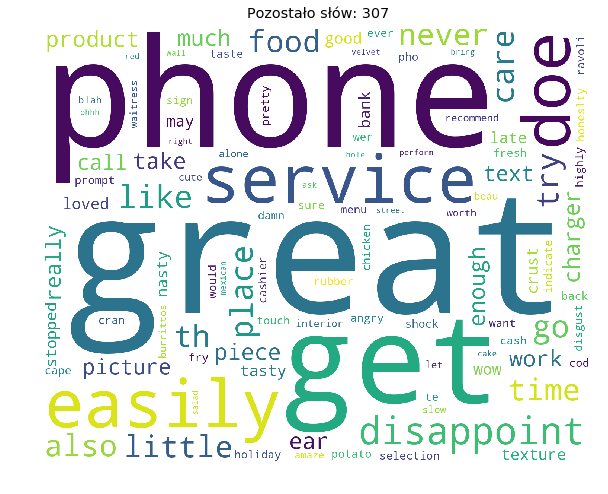

In [221]:
df_text_str = str(df.text)
df_text_spacy_tokenizer = spacy_tokenizer(df_text_str)
len_spacy_tokenizer = 'Pozostało słów: ' + str(len(df_text_spacy_tokenizer))

wc = WordCloud(max_words=100, margin=10, background_color='white', stopwords=[],
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(df_text_spacy_tokenizer))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.title(len_spacy_tokenizer)
plt.axis("off")
plt.show()

#### Użycie lematyzacji z pakietu SpaCy spowodowało, że ze zbioru 3516 słów pochodzących z recenzji, pozostało ich 307.   
  
Na podstawie analizy chmury 100 najpopularniejszych słów, lematyzer poradził sobie lepiej z usunięciem stopwordów i skrótów w porównaniu do WordNet Lemmatizer.   
  
Jednocześnie zostawił on więcej słów, niż poprzedni lemmatyzer.

# Transformacja macierzy słów

#### W celu transformacji macierzy słów wykorzystałem 3 metody przekształcenia:
- na bazie liczebności słów (CountVectorizer), 
- TfIdf (term frequency inverse document frequency) 
- HashingVectorizer, pozwalający na ograniczenie wielkości słownika. 

# 1. CountVectorizer - macierz liczności słów (Term-Document Matrix)

#### Powszechny schemat reprezentacji związku pomiędzy termami, a dokumentami: polega na sprawdzeniu, jak często dany term (słowo) występuje w poszczególnych dokumentach. 

### 1a. CountVectorizer + brak oczyszczenia tekstu

In [14]:
# m_1a - CountVectorizer bez tokenizera i oczyszczania tekstu
m_1a = CountVectorizer(lowercase=False)

# użycie metody na zbiorze przykładowym
ex_1a = m_1a.fit_transform(corpus)
ex_tokens = m_1a.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_1a, ex_tokens)

,Crust,The,and,good,great,is,menu,not,on,prices,selection,so,the,was,were
Doc0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0
Doc1,0,1,1,0,1,0,1,0,1,1,1,1,2,1,1


Powyższa metoda zlicza ilość wystąpienia danego słowa w całym dokumencie. W przypadku drugiego dokumentu, słowo "the" występuje dwa razy, dlatego została przyporządkowana liczba 2. 

#### Użycie CountVectorizer + brak oczyszczania tekstu na zbiorze recenzji 

In [237]:
test = m_1a.fit_transform(df.text)
ex_tokens = m_1a.get_feature_names()
print('Po użyciu opisanego wyżej rozwiązania, pozostało: ' + str(len(ex_tokens)) + ' zmiennych')

Po użyciu opisanego wyżej rozwiązania, pozostało: 5888 zmiennych


### 1b. CountVectorizer + basic tokenizer

In [15]:
# m_1b - CountVectorizer z basic tokenizerem
m_1b = CountVectorizer(tokenizer=basic_tokenizer)

# użycie metody na zbiorze przykładowym
ex_1b = m_1b.fit_transform(corpus)
ex_tokens = m_1b.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_1b, ex_tokens)

,crust,good,great,menu,prices,selection
Doc0,1,1,0,0,0,0
Doc1,0,0,1,1,1,1


#### Użycie CountVectorizer + basic tokenizer na zbiorze recenzji 

In [239]:
test = m_1b.fit_transform(df.text)
ex_tokens = m_1b.get_feature_names()
print('Po użyciu opisanego wyżej rozwiązania, pozostało: ' + str(len(ex_tokens)) + ' zmiennych')

Po użyciu opisanego wyżej rozwiązania, pozostało: 5180 zmiennych


### 1c. CountVectorizer + lemming tokenizer (WordNet)

In [16]:
# m_1c - CountVectorizer z lemming tokenizerem (WordNet)
m_1c = CountVectorizer(tokenizer=lemming_tokenizer)

# użycie metody na zbiorze przykładowym
ex_1c = m_1c.fit_transform(corpus)
ex_tokens = m_1c.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_1c, ex_tokens)

,crust,good,great,menu,price,selection
Doc0,1,1,0,0,0,0
Doc1,0,0,1,1,1,1


#### Użycie CountVectorizer + lemming tokenizer na zbiorze recenzji 

In [240]:
test = m_1c.fit_transform(df.text)
ex_tokens = m_1c.get_feature_names()
print('Po użyciu opisanego wyżej rozwiązania, pozostało: ' + str(len(ex_tokens)) + ' zmiennych')

Po użyciu opisanego wyżej rozwiązania, pozostało: 4795 zmiennych


### 1d. CountVectorizer + Spacy tokenizer 

In [17]:
# m_1d - CountVectorizer z spacy tokenizerem (Spacy)
m_1d = CountVectorizer(tokenizer=spacy_tokenizer)

# użycie metody na zbiorze przykładowym
ex_1d = m_1d.fit_transform(corpus)
ex_tokens = m_1d.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_1d, ex_tokens)

,crust,good,great,menu,price,selection
Doc0,1,1,0,0,0,0
Doc1,0,0,1,1,1,1


#### Użycie CountVectorizer + Spacy tokenizer na zbiorze recenzji 

In [241]:
test = m_1d.fit_transform(df.text)
ex_tokens = m_1d.get_feature_names()
print('Po użyciu opisanego wyżej rozwiązania, pozostało: ' + str(len(ex_tokens)) + ' zmiennych')

Po użyciu opisanego wyżej rozwiązania, pozostało: 4222 zmiennych


# 2. TdIdf Vectorizer 

#### Modyfikacja klasycznego podejścia term-document matrix. Polega ona na weryfikacji relacji, jaka występuje pomiędzy wystąpieniem danego termu w danym dokumencie, a odwróconą częstotliwością występowania termu w całej kolekcji dokumentów.

### 2a. TdIdfVectorizer + brak oczyszczenia tekstu

In [18]:
# m_2a - TfIdfVectorizer bez tokenizera i oczyszczania tekstu
m_2a = TfidfVectorizer(lowercase=False)

# użycie metody na zbiorze przykładowym
ex_2a = m_2a.fit_transform(corpus)
ex_tokens = m_2a.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_2a, ex_tokens)

,Crust,The,and,good,great,is,menu,not,on,prices,selection,so,the,was,were
Doc0,0.5,0.000000,0.000000,0.5,0.000000,0.5,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Doc1,0.0,0.267261,0.267261,0.0,0.267261,0.0,0.267261,0.0,0.267261,0.267261,0.267261,0.267261,0.534522,0.267261,0.267261


### 2b. TfIdfVectorizer + basic tokenizer

In [19]:
# m_2b - TfIdfVectorizer z basic tokenizerem
m_2b = TfidfVectorizer(tokenizer=basic_tokenizer)

# użycie metody na zbiorze przykładowym
ex_2b = m_2b.fit_transform(corpus)
ex_tokens = m_2b.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_2b, ex_tokens)

,crust,good,great,menu,prices,selection
Doc0,0.707107,0.707107,0.0,0.0,0.0,0.0
Doc1,0.000000,0.000000,0.5,0.5,0.5,0.5


### 2c. TfIdfVectorizer + lemming tokenizer (WordNet)

In [20]:
# m_2c - TfIdfVectorizer z lemming tokenizerem (WordNet)
m_2c = TfidfVectorizer(tokenizer=lemming_tokenizer)

# użycie metody na zbiorze przykładowym
ex_2c = m_2c.fit_transform(corpus)
ex_tokens = m_2c.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_2c, ex_tokens)

,crust,good,great,menu,price,selection
Doc0,0.707107,0.707107,0.0,0.0,0.0,0.0
Doc1,0.000000,0.000000,0.5,0.5,0.5,0.5


### 2d. TfIdfVectorizer + Spacy tokenizer 

In [21]:
# m_2d - TfIdfVectorizer z spacy tokenizerem (Spacy)
m_2d = TfidfVectorizer(tokenizer=spacy_tokenizer)

# użycie metody na zbiorze przykładowym
ex_2d = m_2d.fit_transform(corpus)
ex_tokens = m_2d.get_feature_names()

# funkcja do utworzenia dataframe i wyświetlenia macierzy
wm2df(ex_2d, ex_tokens)

,crust,good,great,menu,price,selection
Doc0,0.707107,0.707107,0.0,0.0,0.0,0.0
Doc1,0.000000,0.000000,0.5,0.5,0.5,0.5


# 3. HashingVectorizer

#### Metoda optymalizująca czas obliczeń poprzez nadanie hashów na termy, dzięki czemu nie trzeba obliczać całej macierzy TDM. Istnieje ryzyko kolizji hashów, co wpłynie na nieprawidłową reprezentację termów. Aby tego uniknąć, wg dokumentacji HashingVectorizer, liczba n_features powinna być wystarczająco wysoka = 2**18.

In [97]:
# m_2d - metoda HashingVectorizer
m_3 = HashingVectorizer(n_features=2**18)

# użycie metody na zbiorze przykładowym
ex_3 = m_3.fit_transform(corpus)

print(ex_3.shape)
print(ex_3.toarray())

(2, 262144)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Podział na zbiór treningowy i testowy 

W celu podziału zbioru recenzji i sentymentu na zbiór treningowy i testowy, wykorzystałem funkcję train_test_split. Jako jej parametry przyjąłem test_size równy 0,3 - wykorzystywany na zajęciach oraz random_state=1, aby móc porównywać wyniki w razie wielokrotnych przetwarzań.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.3, random_state=1)

# Przykładowy BaseEstimator

Aby sprawdzić, jaki wynik nauczenia modelu klasyfikacji będzie wystarczająco dobry, wykorzystałem metodę BaseEstimatora.  
Polega ona naiwnej nauce estymatora, polegającej na nieprzyznawaniu 1 poszczególnym obserwacjom. Jeśli klasy były zbalansowane, base estimator powinien mieć accuracy w pobliżu 50% (będzie przyznawał zawsze 0).

#### BaseEstimator - funkcja i nauczanie modelu

In [99]:
from sklearn.base import BaseEstimator
class Never1Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [100]:
from sklearn.model_selection import cross_val_score
never_1_clf = Never1Classifier()
cross_val_score(never_1_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.5226209 , 0.50234009, 0.49609984])

#### 50-52% skuteczności - wszystko, co będzie lepsze, jest dobre
Wynik zgodny z przewidywanym, ponieważ wcześniej zweryfikowano zbalansowanie klas.

# Ocena klasyfikacji

#### Ze względu na postawione zadanie klasyfikacyjne, do wyboru modelu zostanie zastosowana ocena classification report, sprawdzającego uzyskane precision, recall oraz f1-score. 

## report for grid-search

Poniższy fragment kodu wyświetla wyniki uzyskane poprzez poszczególne modele (mean test score i std test score):

In [ ]:
def report(results, n_top=12):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Classification report

#### Precyzja:
- ilość obserwacji poprawnie zaklasyfikowanych podzielona przez sumę ilości obserwacji poprawnie zaklasyfikowanych oraz niepoprawnie zaklasyfikowanych (TP / TP+FN)
  
#### Recall;
- ilość obserwacji poprawnie zaklasyfikowanych podzielona przez sumę ilości obserwacji poprawnie zaklasyfikowanych oraz poprawnie odrzuconych (TP / TP+TN)
  
#### F1 score: 
- miara mająca na celu wspólną ocenę parametrów precyzji i recall, bazująca na wartościach tych parametrów. 
  
#### Im wyższe wartości, tym lepszy wynik.

## ROC

#### Metodą oceny jakości klasyfikatora jest ROC - wykres pokazujący zależność pomiędzy TPR (True Positive Rate) oraz FPR (False Positive Rate). 
  
Im krzywa jest mocniej "wypukła", tym klasyfikator jest lepszy -> pole pod krzywą powinny być jak największe (AUC - Area Under ROC Curve). 
  
Przyjmuje się, że wartości AUC powyżej 0,5 są wystarczająco dobre. 

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

# Regresja logistyczna (klasyfikator)

### Jedna z najpopularniejszych metod klasyfikacji dla analizy sentymentu. 
Metoda ta jest wykorzystywana do klasyfikacji binarnej. W przypadku analizowanego problemu, są to wartości 0 dla negatywnego wydźwięku recenzji oraz 1 dla pozytywnego wydźwięku recenzji. 

In [101]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)

pipe = Pipeline([('preprocessing', m_1a), ('classifier', LogisticRegression())])

param_grid = [ {'preprocessing': [m_1a, m_1b, m_1c, m_1d, m_2a, m_2b, m_2c, m_2d, m_3]},
               {'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 10],
                'classifier__penalty' : ['l1', 'l2']
               }
             ]

grid_1 = GridSearchCV(pipe, param_grid = param_grid, cv = kfold, refit=True)

grid_1.fit(X_train, y_train)
print(grid_1.best_params_)

{'preprocessing': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function basic_tokenizer at 0x000001BCEC5FAC80>,
        use_idf=True, vocabulary=None)}


In [181]:
pred_data = grid_1.predict(X_test) 
print("Accuracy:", round(metrics.accuracy_score(y_test, pred_data),2))

Accuracy: 0.79


In [182]:
print(classification_report(y_test, pred_data))
x = list(precision_recall_fscore_support(y_test, pred_data, average='weighted'))
grid_1_report = [round(x,2) for x in x[0:3]]

             precision    recall  f1-score   support

          0       0.76      0.79      0.78       387
          1       0.81      0.78      0.79       438

avg / total       0.79      0.79      0.79       825



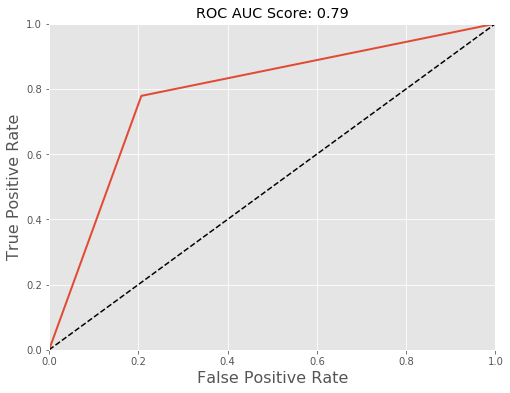

In [183]:
fpr_grid_1, tpr_grid_1, thresholds_grid1 = roc_curve(y_test, pred_data)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_grid_1, tpr_grid_1)
x = 'ROC AUC Score: ' + str(round(roc_auc_score(y_test, pred_data),2))
plt.title(x)
plt.show()

# Random Forest (klasyfikator)

### W porównaniu do regresji logistycznej, jest to mocniej zaawansowana metoda klasyfikacji. 

Polega ona na wielokrotnym wykorzystaniu drzew klasyfikacyjnych do klasyfikacji na różnych podzbiorach danych oraz uśrednaniu wyników przetwarzań w celu trafniejszej oceny. 

In [28]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)

pipe = Pipeline([('preprocessing', m_1a), ('classifier', RandomForestClassifier())])

param_grid = [ {'preprocessing': [m_1a, m_1b, m_1c, m_1d, m_2a, m_2b, m_2c, m_2d, m_3]},
             ]

grid_2 = GridSearchCV(pipe, param_grid = param_grid, cv = kfold, refit=True)

grid_2.fit(X_train, y_train)
print(grid_2.best_params_)

{'preprocessing': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x00000241724DB730>,
        use_idf=True, vocabulary=None)}


In [29]:
pred_data = grid_2.predict(X_test) 
print("Accuracy:", round(metrics.accuracy_score(y_test, pred_data),2))

Accuracy: 0.7333333333333333


In [30]:
print(classification_report(y_test, pred_data))
x = list(precision_recall_fscore_support(y_test, pred_data, average='weighted'))
grid_2_report = [round(x,2) for x in x[0:3]]

             precision    recall  f1-score   support

          0       0.66      0.87      0.75       387
          1       0.84      0.61      0.71       438

avg / total       0.76      0.73      0.73       825



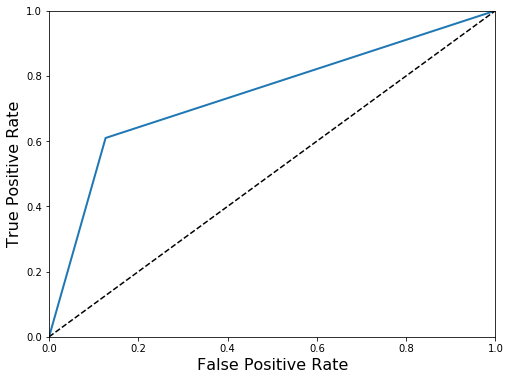

In [32]:
fpr_grid_2, tpr_grid_2, thresholds_grid2 = roc_curve(y_test, pred_data)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_grid_2, tpr_grid_2)
x = 'ROC AUC Score: ' + str(round(roc_auc_score(y_test, pred_data),2))
plt.title(x)
plt.show()

### W celu potencjalnie lepszego wyniku klasyfikatora, poniżej wprowadziłem zmienne do grid searcha: różne wartości n_estimators i max_depth

In [34]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)

pipe = Pipeline([('preprocessing', m_1a), ('classifier', RandomForestClassifier())])

param_grid = [ {'preprocessing': [m_1a, m_1b, m_1c, m_1d, m_2a, m_2b, m_2c, m_2d, m_3]},
              {'classifier__n_estimators': [1, 2, 4, 8, 16, 32],
              'classifier__max_depth': [1, 3, 5, 7]}
             ]

grid_3 = GridSearchCV(pipe, param_grid = param_grid, cv = kfold, refit=True)

grid_3.fit(X_train, y_train)
print(grid_3.best_params_)

{'preprocessing': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function basic_tokenizer at 0x000001BCEC5FAC80>,
        use_idf=True, vocabulary=None)}


In [36]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [38]:
pred_data = grid_3.predict(X_test) 
print("Accuracy:", round(metrics.accuracy_score(y_test, pred_data),2))

Accuracy: 0.7103030303030303


In [39]:
print(classification_report(y_test, pred_data))
x = list(precision_recall_fscore_support(y_test, pred_data, average='weighted'))
grid_3_report = [round(x,2) for x in x[0:3]]

             precision    recall  f1-score   support

          0       0.64      0.86      0.74       387
          1       0.82      0.58      0.68       438

avg / total       0.74      0.71      0.71       825



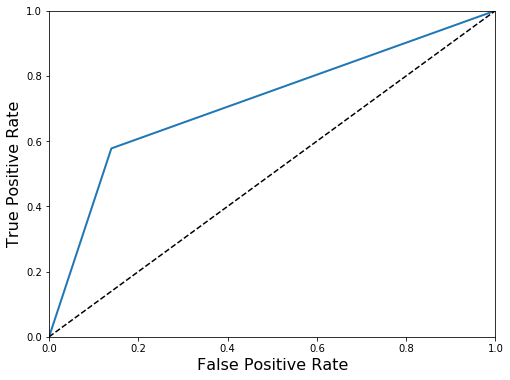

In [40]:
fpr_grid_3, tpr_grid_3, thresholds_grid3 = roc_curve(y_test, pred_data)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_grid_3, tpr_grid_3)
x = 'ROC AUC Score: ' + str(round(roc_auc_score(y_test, pred_data),2))
plt.title(x)
plt.show()

# Multinomial NB 

### Metoda klasyfikacji bazująca na teorii Bayesa o niezależności między parami cech przy danej wartości zmienne klasy

Metoda ta jest szeroko wykorzystywana w analizach tekstu ze względu na prostotę jej zastosowania oraz wysokie wyniki w przypadku klasyfikacji binarnej.

In [35]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)

pipe = Pipeline([('preprocessing', m_1a), ('classifier', MultinomialNB())])

param_grid = [ {'preprocessing': [m_1a, m_1b, m_1c, m_1d, m_2a, m_2b, m_2c, m_2d]}]

grid_4 = GridSearchCV(pipe, param_grid = param_grid, cv = kfold, refit=True)

grid_4.fit(X_train, y_train)
print(grid_4.best_params_)

{'preprocessing': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function basic_tokenizer at 0x000001BCEC5FAC80>,
        use_idf=True, vocabulary=None)}


In [37]:
pred_data = grid_4.predict(X_test) 
print("Accuracy:", round(metrics.accuracy_score(y_test, pred_data),2))

Accuracy: 0.7987878787878788


In [38]:
print(classification_report(y_test, pred_data))
x = list(precision_recall_fscore_support(y_test, pred_data, average='weighted'))
grid_4_report = [round(x,2) for x in x[0:3]]

             precision    recall  f1-score   support

          0       0.78      0.80      0.79       387
          1       0.82      0.80      0.81       438

avg / total       0.80      0.80      0.80       825



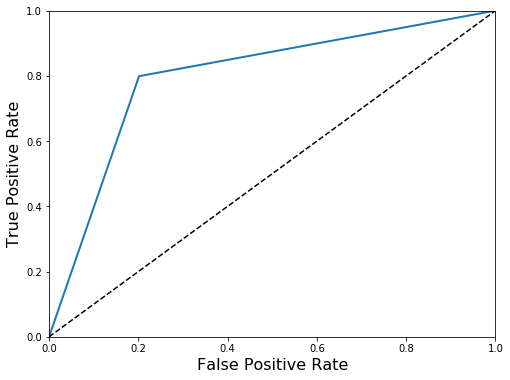

In [39]:
fpr_grid_4, tpr_grid_4, thresholds_grid4 = roc_curve(y_test, pred_data)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_grid_4, tpr_grid_4)
x = 'ROC AUC Score: ' + str(round(roc_auc_score(y_test, pred_data),2))
plt.title(x)
plt.show()

# SVC - Support-vector machine

### Metoda polegająca na podzieleniu płaszczyzny za pomocą wektora, który dzieli elementy przypisując je do jednej z dwóch klas.

In [45]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)

pipe = Pipeline([('preprocessing', m_1a), ('classifier', SVC())])

param_grid = [ {'preprocessing': [m_1a, m_1b, m_1c, m_1d, m_2a, m_2b, m_2c, m_2d]},
               {'classifier__gamma': [0.1, 0.5, 1],
                'classifier__C': [0.1, 0.5, 1]
               }
             ]

grid_5 = GridSearchCV(pipe, param_grid = param_grid, cv = kfold, refit=True)

grid_5.fit(X_train, y_train)
print(grid_5.best_params_)


{'classifier__C': 1, 'classifier__gamma': 0.1}


In [46]:
pred_data = grid_5.predict(X_test) 
print("Accuracy:", round(metrics.accuracy_score(y_test, pred_data),2))

Accuracy: 0.7260606060606061


In [47]:
print(classification_report(y_test, pred_data))
x = list(precision_recall_fscore_support(y_test, pred_data, average='weighted'))
grid_5_report = [round(x,2) for x in x[0:3]]

             precision    recall  f1-score   support

          0       0.67      0.81      0.73       387
          1       0.79      0.66      0.72       438

avg / total       0.74      0.73      0.73       825



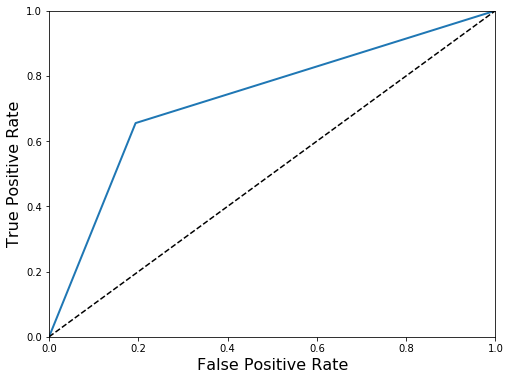

In [48]:
fpr_grid_5, tpr_grid_5, thresholds_grid5 = roc_curve(y_test, pred_data)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_grid_5, tpr_grid_5)
x = 'ROC AUC Score: ' + str(round(roc_auc_score(y_test, pred_data),2))
plt.title(x)
plt.show()

# Ocena klasyfikatorów

Aby uniknąć ponownego przetwarzania, poniżej tylko jedną linijkę wpisuję za pomocą funkcji do tabeli, a pozostałe wpisuję "z palca", bazując na wcześniej uzyskanych classification reports.

In [273]:
scores = pd.DataFrame(columns=['Precision', 'Recall', 'F1 score'])
scores.loc['Logistic Regression'] = [grid_1_report[0], grid_1_report[1], grid_1_report[2]]
scores.loc['Random Forest - default'] = [0.76, 0.73, 0.73]
scores.loc['Random Forest - hyperparameters'] = [0.74, 0.71, 0.71]
scores.loc['Multinomial NB'] = [0.80, 0.80, 0.80]
scores.loc['SVC'] = [0.74, 0.73, 0.73]

scores.head()

,Precision,Recall,F1 score
Logistic Regression,0.79,0.79,0.79
Random Forest - default,0.76,0.73,0.73
Random Forest - hyperparameters,0.74,0.71,0.71
Multinomial NB,0.80,0.80,0.80
SVC,0.74,0.73,0.73


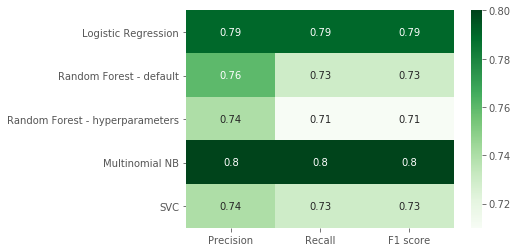

In [279]:
sns.heatmap(scores, annot=True, cmap="Greens")
plt.show()

# Najlepsze wyniki osiągnięto dla modelu Multinomial NB -> F1 score = 0.8

Wskaźnik F1 score dla modelu Multinomial NB jest najwyższy i wynosi 0,8.  
Na drugim miejscu pojawiła się regresja logistyczna z F1 = 0,79.   
Najsłabiej dopasowanym modelem jest las losowy z podanym zestawem parametrów / F1 = 0.71.